# Toxic Comment Classification 
In the digital age, toxic comments pose a significant challenge to online communities. Our mission is to build a Deep Learning model that automatically detects and categorizes toxic comments. This AI-driven solution will enhance online discourse, save time, and protect vulnerable users. Join us in our journey to create a safer online environment.

I used kaggle dataset which can be found here: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview

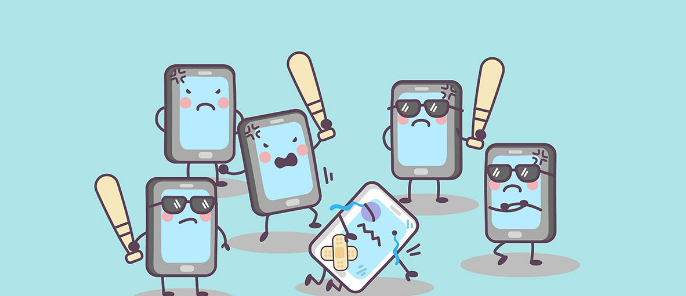

### Importing Libraries and Loading Data

In [63]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [64]:
df = pd.read_csv(os.path.join('toxic_comment_dataset','train.csv', 'train.csv'))

In [65]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [66]:
df.shape

(159571, 8)

In [67]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Preprocessing the Data

In [68]:
from tensorflow.keras.layers import TextVectorization

In [69]:
X = df['comment_text']
y = df[df.columns[2:]]
y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [70]:
y = y.values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [71]:
MAX_WORDS = 200000 # number of words in the vocab

# TextVectorization layer in TensorFlow is a utility that converts raw text data into numerical data that a neural network can process. 
vectorizer = TextVectorization(max_tokens=MAX_WORDS, # This parameter sets the maximum number of tokens (words) to be included in the vocabulary.
                               output_sequence_length=1800, # This parameter specifies the desired length of the output sequences.
                               output_mode='int') # This parameter determines the type of output the TextVectorization layer will produce.
                                                  # 'int' means it will produce integer values representing the tokens.

vectorizer.adapt(X.values) # This line uses the training data to build the vocabulary and configure the text preprocessing. 

vectorized_text = vectorizer(X.values) # This line applies the vectorizer to the entire dataset 

In [72]:
# This code sets up the dataset for training a machine learning model, ensuring that the data is efficiently 
# loaded, shuffled, batched, and prefetched during training.

#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)) # This line creates a TensorFlow Dataset from the provided data. 
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [73]:
dataset.as_numpy_iterator().next()

(array([[  104,     3,    17, ...,     0,     0,     0],
        [  104,   136,   428, ...,     0,     0,     0],
        [   40,    81,    39, ...,     0,     0,     0],
        ...,
        [ 2857,    31,  4764, ...,     0,     0,     0],
        [  278, 42334,    29, ...,     0,     0,     0],
        [15641,     2,   625, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [74]:
# This code is splitting a dataset into three parts: a training set, a validation set, and a test set.
# take() method extracts the specified number of elements from the beginning of the dataset.

train = dataset.take(int(len(dataset)*.7))  # First 70% of the dataset.
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))  # The 20% of the dataset after the tarining set.
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))  # Last 10% of the dataset.

### Creating the Model

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [76]:
model = Sequential()

# Create the embedding layer 
# This line adds an Embedding layer to the model. 
# The Embedding layer is commonly used for processing text data and maps integer-encoded words to dense vectors of fixed size.
model.add(Embedding(MAX_WORDS+1, 32))

# Bidirectional LSTM Layer
# This line adds a Bidirectional LSTM (Long Short-Term Memory) layer to the model. 
# LSTM is a type of recurrent neural network (RNN) that is well-suited for sequential data like text. 
# The Bidirectional wrapper processes the input sequence both forwards and backwards, which can capture long-range dependencies effectively. 
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [77]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [78]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 6)                 774       
                                                      

In [79]:
# This line of code starts the training process for the neural network model. 
history = model.fit(train, epochs=10, validation_data=val)

# I recommend running 5-10 epochs for this dataset.

Epoch 1/10
3963/6981 [================>.............] - ETA: 31:07 - loss: 0.0725

KeyboardInterrupt: 

In [ ]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(8,5))
# pd.DataFrame(history.history).plot()
# plt.show()

### Predictions

In [ ]:
input_text = vectorizer('I hate you')

res = model.predict(np.array([input_text]))
res

In [ ]:
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()

(model.predict(batch_X) > 0.5).astype(int)

### Evaluate the Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Initialize lists to store per-batch results
precision_scores = []
recall_scores = []
accuracy_scores = []

for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    
    # Make predictions
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    # Calculate metrics for this batch
    precision = precision_score(y_true, (yhat >= 0.5).astype(int))
    recall = recall_score(y_true, (yhat >= 0.5).astype(int))
    accuracy = accuracy_score(y_true, (yhat >= 0.5).astype(int))
    
    # Append batch results to the lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

# Calculate the mean of metrics across all batches
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_accuracy = np.mean(accuracy_scores)

print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean Accuracy: {mean_accuracy:.4f}')


In [80]:
import tensorflow as tf
import gradio as gr

model.save('toxicity.h5')
model = tf.keras.models.load_model('toxicity.h5')

input_str = vectorizer('hey i freaken hate you!')

res = model.predict(np.expand_dims(input_str,0))

def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text
    
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

interface.launch(share=True)

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (C:\Users\Orange\AppData\Local\Programs\Python\Python311\Lib\site-packages\typing_extensions.py)